<a href="https://colab.research.google.com/github/cxbxmxcx/Practical_AI_on_GCP/blob/master/Chapter_9_EatNoEat_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import math
import glob
import pickle
import io
import os
import datetime
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
use_NAS = False
if use_NAS:
  IMG_SIZE = 224 # 299 for Inception, 224 for NASNetMobile
  IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
else:
  IMG_SIZE = 299 # 299 for Inception, 224 for NASNetMobile
  IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  if use_NAS:
    img = tf.keras.applications.nasnet.preprocess_input(img)
  else:
    img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
def create_model(image_batch):
  tf.keras.backend.clear_session()

  if use_NAS:
    # Create the base model from the pre-trained model 
    base_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')
  else:
    # Create the base model from the pre-trained model 
    base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  feature_batch = base_model(image_batch)
    
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  prediction_layer = tf.keras.layers.Dense(3)
  prediction_batch = prediction_layer(feature_batch_average)

  model = tf.keras.Sequential([
                               base_model,
                               global_average_layer,
                               prediction_layer])

  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=['mae', 'mse', 'accuracy'])
  return model

In [ ]:
import os
from os import listdir

my_drive = '/content/gdrive/My Drive/'
image_folder = my_drive + 'TestImages/'
models = my_drive + 'Models'
training_folder = my_drive + "Traning/"

def get_test_images(directory):  
  images = []
  for file in listdir(directory):    
    if file.endswith(".jpg"):      
      images.append(image_folder + file)
  return images

images = get_test_images(image_folder)
print(images)

['/content/gdrive/My Drive/TestImages/french_toast.jpg', '/content/gdrive/My Drive/TestImages/pizza.jpg', '/content/gdrive/My Drive/TestImages/bip.jpg', '/content/gdrive/My Drive/TestImages/poutine.jpg', '/content/gdrive/My Drive/TestImages/hot_dog.jpg', '/content/gdrive/My Drive/TestImages/apple_pie.jpg', '/content/gdrive/My Drive/TestImages/ramen.jpg', '/content/gdrive/My Drive/TestImages/hamburger.jpg', '/content/gdrive/My Drive/TestImages/ribs.jpg', '/content/gdrive/My Drive/TestImages/fish_and_chips.jpg', '/content/gdrive/My Drive/TestImages/steak.jpg', '/content/gdrive/My Drive/TestImages/prime_rib.jpg', '/content/gdrive/My Drive/TestImages/pie.jpg', '/content/gdrive/My Drive/TestImages/french_toast2.jpg', '/content/gdrive/My Drive/TestImages/fried_chicken.jpg', '/content/gdrive/My Drive/TestImages/peking_duck.jpg', '/content/gdrive/My Drive/TestImages/beef_taco.jpg', '/content/gdrive/My Drive/TestImages/shrimp_and_grits.jpg', '/content/gdrive/My Drive/TestImages/chocolate_cake.j

In [ ]:
if len(images) < 0:
  raise Exception('Test images need to be loaded!')
else: 
  x, _ = load_image(images[0])
  img = x[np.newaxis, ...]

  food_model = create_model(img)
  food_model.summary()

219062272/219055592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
latest = tf.train.latest_checkpoint(models)
latest
if latest != None:
  food_model.load_weights(latest)

In [ ]:
def observe_image(image, model):  
  x, _ = load_image(image)  
  img = x[np.newaxis, ...]
  return model.predict(img)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Javascript

test_states = []

Label(value='Images Trained 1')

[[2.9628532 7.710639  3.8344636]]
19 /content/gdrive/My Drive/TestImages/churro.jpg


ToggleButtons(options=('Eat', 'No Eat'), value='Eat')

Button(description='Train!', style=ButtonStyle())

Output()

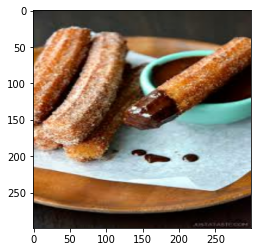

In [ ]:
#@title Eat/No Eat Training { run: "auto", vertical-output: true, display-mode: "form" }
image_idx = 19 #@param {type:"slider", min:0, max:100, step:1}

val = f"Images Trained {len(test_states)}"
label = widgets.Label(
    value= val,    
    disabled=False
)
display(label)

cnt = len(images)
image_idx = image_idx if image_idx < cnt else cnt - 1
image = images[image_idx]
x, _ = load_image(image)  
img = x[np.newaxis, ...]
predict = food_model.predict(img)
print(predict+5)
print(image_idx,image)
plt.imshow((x+1)/2)

toggle = widgets.ToggleButtons(
    options=['Eat', 'No Eat'],
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
#     icon='check'
)
display(toggle)

button = widgets.Button(description="Train!")
output = widgets.Output()

def button_clicked(b):
  # Display the message within the output widget.
  with output:    
    test = (predict,toggle.index,image)
    test_states.append(test) 

button.on_click(button_clicked)
display(button, output)


In [ ]:
if len(test_states) > 0:
  if os.path.isdir(training_folder) == False:
    os.makedirs(training_folder)
  pickle.dump( test_states, open( training_folder + "food_test.p", "wb" ) )